# Flann usage applied to AKAZE, ORB and SIFT descriptors

In [11]:
from src.utils import image_utils, notebook_utils

from src.process import feature_extraction
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, Tuple
import time


def LowesRatio(matches : list[cv.DMatch]) -> list[cv.DMatch]:
    goodMatches = []
    for pair in matches:
        if len(pair) < 2:
            continue
        m, n = pair
        if m.distance < 0.75 * n.distance: 
            goodMatches.append(m)

    return goodMatches

def EvaluateFeatureMatcher(images : Tuple[cv.Mat, cv.Mat], descriptor, descriptorParams : dict, descriptorMatcher : cv.DescriptorMatcher, descriptorMatcherParams):
    kp1, des1 = descriptor(images[0], **descriptorParams)
    kp2, des2 = descriptor(images[1], **descriptorParams)

    flannParams = (descriptorMatcherParams["index_params"], descriptorMatcherParams["search_params"])
    matcher : cv.DescriptorMatcher = descriptorMatcher(*flannParams)

    matchesFound = matcher.knnMatch(des1, des2, 2)
    goodMatches = LowesRatio(matchesFound)

    style = dict(
        matchColor = (255, 0, 0), #Cor das linhas = vermelho
        singlePointColor = (0, 255, 0), #Cor dos pontos = verde
        flags = cv.DRAW_MATCHES_FLAGS_DEFAULT
    )
    res = cv.drawMatches(images[0], kp1, images[1], kp2, goodMatches, None, **style)

    return (matchesFound, goodMatches, res)
    

In [12]:

icPictures = image_utils.load_raw_images("FotosICMural")
img1 = cv.cvtColor(icPictures["1"], cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(icPictures["2"], cv.COLOR_BGR2RGB)

FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH,
                    table_number=12,   # 12 is recommended
                    key_size=20,       # 20 is recommended
                    multi_probe_level=2) # 2 is recommended
search_params = dict(checks=50)  # How many times the trees are recursively traversed


binDescriptorFlannParams = dict(index_params=index_params, search_params=search_params)


ORB
Matches:	50000
GoodMatches:	4142
Ratio:	0.08284
Time elapsed:	9.454315185546875

AKAZE
Matches:	40295
GoodMatches:	5552
Ratio:	0.13778384414939818
Time elapsed:	12.372669219970703

SIFT
Matches:	157214
GoodMatches:	12344
Ratio:	0.07851718040378083
Time elapsed:	9.37499451637268



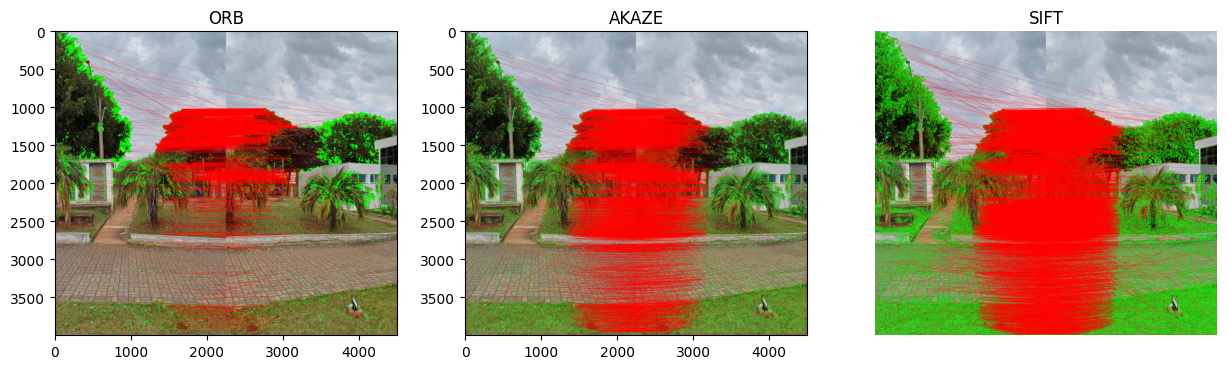

In [13]:
index_params = dict(algorithm=1,
                    table_number=12,   # 12 is recommended
                    key_size=20,       # 20 is recommended
                    multi_probe_level=2) # 2 is recommended
search_params = dict(checks=50)  # How many times the trees are recursively traversed
siftParams = dict(index_params=index_params, search_params=search_params)

images = (img1, img2)
inputSuite = list([
    (images, feature_extraction.ORB, dict(nfeatures=50000), cv.FlannBasedMatcher, binDescriptorFlannParams),
    (images, feature_extraction.AKAZE, {}, cv.FlannBasedMatcher, binDescriptorFlannParams),
    (images, feature_extraction.SIFT, {}, cv.FlannBasedMatcher, siftParams)
])

fig, axes = plt.subplots(1, len(inputSuite), figsize=(15, 15))
for i, item in enumerate(inputSuite):
    descrName = item[1].__name__

    timerStart = time.time()
    allMatches, goodMatches, arrowView = EvaluateFeatureMatcher(*item)
    timerEnd = time.time()

    print(f"{descrName}\n" +
    f"Matches:\t{len(allMatches)}\n" +
    f"GoodMatches:\t{len(goodMatches)}\n" +
    f"Ratio:\t{len(goodMatches)/len(allMatches)}\n"
    f"Time elapsed:\t{timerEnd - timerStart}\n"
    )

    image_utils.save_image(arrowView, f"{descrName}-pair")
    axes[i].set_title(descrName)
    axes[i]
    axes[i].imshow(arrowView)
    
plt.axis("off")
plt.show()